In [12]:
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Data Preparation

In [14]:
data_backup = pd.read_csv("flo_data_20k.csv")

In [15]:
data = data_backup.copy()

In [16]:
def outlier_thresholds(dataframe,variable):
    q1 = dataframe[variable].quantile(0.05)
    q3 = dataframe[variable].quantile(0.95)
    iqr = q3 - q1
    up_limit = q3 + iqr * 1.5
    low_limit = q1 - iqr * 1.5

    return low_limit,up_limit

In [17]:
def replace_with_tresholds(dataframe,variable):
    low_limit , up_limit = outlier_thresholds(dataframe,variable)
    dataframe.loc[(dataframe[variable] < low_limit) , variable ] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit) , variable ] = up_limit

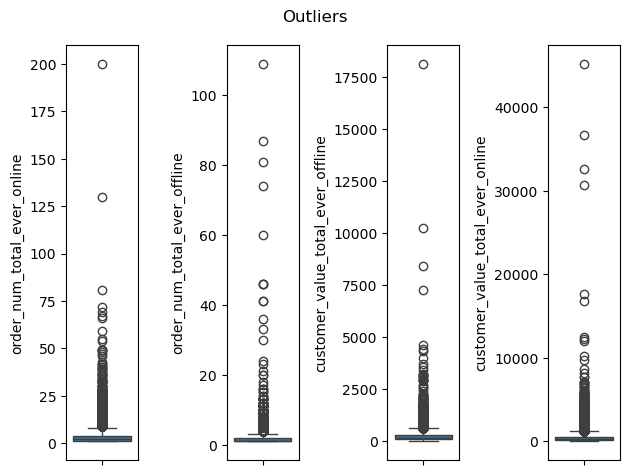

In [18]:
fig,ax = plt.subplots(1,4)

variables = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline",
"customer_value_total_ever_online"]

for i,var in enumerate(variables):

    sns.boxplot(data[var],ax=ax[i])
    plt.tight_layout()
    fig.suptitle("Outliers")

In [19]:
for i in variables:
    replace_with_tresholds(data,i)

In [20]:
data["order_num_total_ever_offline"] = round(data["order_num_total_ever_offline"])
data["order_num_total_ever_online"] = round(data["order_num_total_ever_online"])

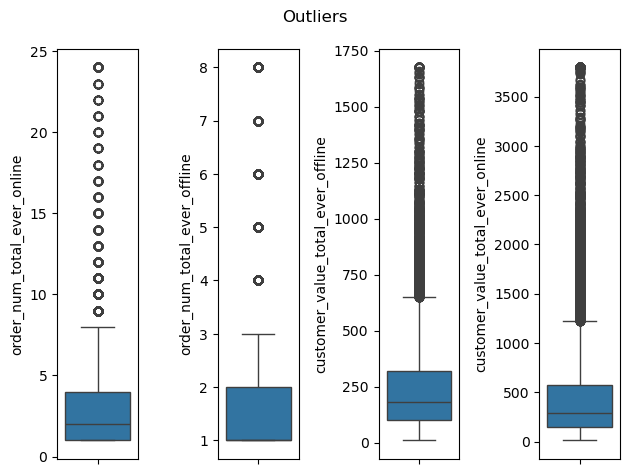

In [21]:
fig,ax = plt.subplots(1,4)

variables = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline",
"customer_value_total_ever_online"]

for i,var in enumerate(variables):

    sns.boxplot(data[var],ax=ax[i])
    plt.tight_layout()
    fig.suptitle("Outliers")

In [22]:
data["frequency"] = data["order_num_total_ever_online"] + data["order_num_total_ever_offline"]
data["total_price"] = data["customer_value_total_ever_online"] + data["customer_value_total_ever_offline"]

In [23]:
time_columns = ["first_order_date","last_order_date","last_order_date_online","last_order_date_offline"]
data[time_columns] = data[time_columns].astype('datetime64[ns]')

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

# Analysis

In [26]:
analyis_date = data["last_order_date"].max() + pd.Timedelta(days=2) # The analysis day was set as 2 days after the latest date.

In [27]:
cltv = pd.DataFrame()

In [28]:
cltv["customer_id"] = data["master_id"]

recency = data["last_order_date"] - data["first_order_date"]
cltv["recency_cltv_weekly"] = recency.apply(lambda date : date.days) / 7


tenure = analyis_date - data["first_order_date"]
cltv["T_weekly"] = tenure.apply(lambda date : date.days) / 7

cltv["frequency"] = data["frequency"]

cltv["monetary_cltv_avg"] = data["total_price"] / data["frequency"]

## BG / NBD (Beta Geometric / Negative Binomial Distribution)

In [30]:
bg = BetaGeoFitter(penalizer_coef=0.0001)

In [31]:
bg.fit(cltv["frequency"],
       cltv["recency_cltv_weekly"],
       cltv["T_weekly"])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 94.12, b: 0.00, r: 4.45>

In [32]:
cltv["exp_sales_3_month"] = bg.conditional_expected_number_of_purchases_up_to_time(12,
                                                                                   cltv["frequency"],
                                                                                   cltv["recency_cltv_weekly"],
                                                                                   cltv["T_weekly"])

cltv["exp_sales_6_month"] = bg.conditional_expected_number_of_purchases_up_to_time(24,
                                                                                   cltv["frequency"],
                                                                                   cltv["recency_cltv_weekly"],
                                                                                   cltv["T_weekly"])

## Gamma Gamma Submodel

In [34]:
gamma = GammaGammaFitter(penalizer_coef= 0.001)

In [35]:
gamma.fit(cltv["frequency"],
          cltv["monetary_cltv_avg"])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 13.21, q: 1.70, v: 12.97>

In [36]:
cltv["exp_average_value"] = gamma.conditional_expected_average_profit(cltv["frequency"],
                                                                      cltv["monetary_cltv_avg"])

## CLTV

In [38]:
cltv["cltv"] = gamma.customer_lifetime_value(bg,
                                             cltv["frequency"],
                                             cltv["recency_cltv_weekly"],
                                             cltv["T_weekly"],
                                             cltv["monetary_cltv_avg"],
                                             time = 6 , # 6 month
                                             freq = "W", # customer tenure type 
                                             discount_rate= 0.10)

In [39]:
cltv.sort_values(by="cltv" , ascending=False).head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.857,7.857,4.000,1065.692,0.994,1.988,1054.945,1653.265
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.429,34.429,8.000,601.226,1.162,2.324,598.877,1097.175
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.143,13.143,11.000,394.070,1.728,3.456,393.352,1071.832
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.286,9.429,2.000,862.690,0.747,1.494,846.718,997.334
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.857,15.571,3.000,743.587,0.814,1.629,734.916,943.950


In [40]:
cltv["segment"] = pd.qcut(cltv["cltv"],q=4,labels =["D","C","B","A"])

In [41]:
cltv.groupby("segment").agg({"exp_average_value":("count","mean"),
                            "exp_sales_6_month":("mean"),
                            "cltv":("mean"),
                            "frequency":("mean")})

exp_average_value         exp_sales_6_month    cltv frequency
                    count    mean              mean    mean      mean
segment                                                              
D                    4987  94.896             0.838  59.867     3.737
C                    4986 127.811             1.046 100.682     4.344
B                    4986 161.743             1.183 143.438     5.084
A                    4986 228.763             1.468 251.000     6.480